In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import rfp
import utils
import mac

In [47]:
# FRF teórica, con 2 picos acoplados y un 3ero lejano
f_n = np.array(([10, 12, 60]))
w_n = 2*np.pi*f_n
xi_n = np.array(([0.05, 0.045, 0.025]))
r_n = np.array(([200*np.exp(1j*np.pi), 150*np.exp(1j*np.pi), 2500]))

w = np.linspace(0,400,4001)
f = w/2/np.pi

In [48]:
frf = np.zeros(len(w), dtype=complex)
for k in range(len(r_n)):
    frf += r_n[k] / (w_n[k]**2 - w**2 + 1j*2*w*w_n[k]*xi_n[k])

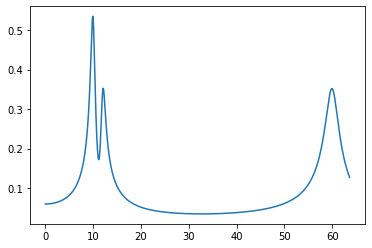

In [49]:
plt.plot(f, abs(frf))
plt.show()

Frequencias: [10. 12. 60.] Hz
Amortiguamientos: [0.05  0.045 0.025]
Magnitudes Modales: [ 200.     150.    2500.004]
Fases Modales: [-1.  1. -0.]*pi


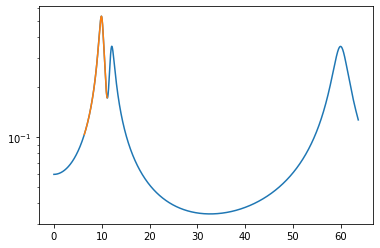

In [50]:
# Parametrización modal del 1er pico por RFP
n_modes = 3
n = 2*n_modes
m = 2*n_modes - 1
modal_params, alpha = rfp.rfp(frf[400:700], w[400:700], n, m)
freq_n, xi_n, modal_mag_n, modal_ang_n = modal_params

print('Frequencias: {} Hz'.format(np.round(freq_n, 2)))
print('Amortiguamientos: {}'.format(np.round(xi_n, 3)))
print('Magnitudes Modales: {}'.format(np.round(modal_mag_n, 3)))
print('Fases Modales: {}*pi'.format(np.round(modal_ang_n/np.pi, 3)))
plt.semilogy(f, abs(frf))
plt.plot(f[400:700], abs(alpha))
plt.show()

### GRFP

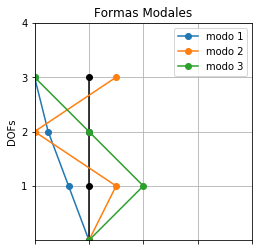

In [51]:
# Ampliación de los residuos a varias mediciones
r_n0 = np.array(([75*np.exp(1j*np.pi), 75*np.exp(0), 2500*np.exp(0)]))
r_n1 = np.array(([150*np.exp(1j*np.pi), 150*np.exp(1j*np.pi), 0]))
r_n2 = np.array(([200*np.exp(1j*np.pi), 75*np.exp(0), 2500*np.exp(1j*np.pi)]))

r_n = np.array([r_n0, r_n1, r_n2])
n_dof = r_n.shape[0]
n_modes = r_n.shape[1]
utils.plot_column_modes(r_n)

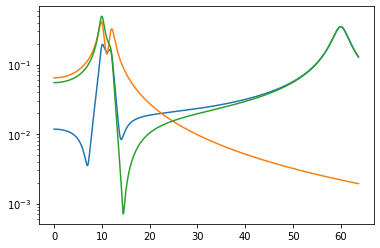

In [52]:
# Obtención de las distintas FRF
frf = np.zeros((len(w), n_dof), dtype=complex)
for dof in range(n_dof):
    for mode in range(n_modes):
        frf[:, dof] += r_n[dof, mode] / (w_n[mode]**2 - w**2 + 1j*2*w*w_n[mode]*xi_n[mode])

plt.semilogy(f, np.abs(frf))
plt.show()

### Parametrización por GRFP de los 1eros 2 picos

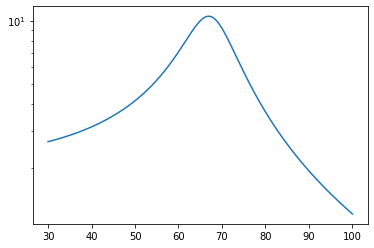

In [54]:
# Obtencion del polinomio denominador
idx12 = np.linspace(300, 1000, 701, dtype=int)
w12 = w[idx12]
n_modes = 2
n = 2*n_modes
m = 2*n_modes - 1+4
denominator, denominator_coeff = rfp.grfp_denominator(frf[idx12, :], w12, n, m)

plt.semilogy(w12, np.abs(1/denominator))
plt.show()

In [55]:
# Obtencion de los parametros modales de cada FRF
modal_params, frf_estimates = rfp.grfp_parameters(frf[idx12, :], w12, denominator, denominator_coeff, m)

ValueError: could not broadcast input array from shape (3) into shape (7)

Frequencias: [10.01 12.02] Hz
Amortiguamientos: [0.05  0.045]


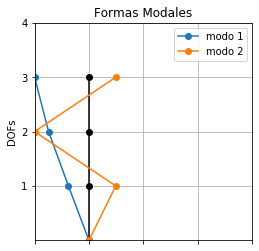

In [13]:
freq_n, xi_n, modal_mag_n, modal_ang_n = modal_params
mode_vectors = (modal_mag_n*np.exp(1j*modal_ang_n)).T

print('Frequencias: {} Hz'.format(np.round(freq_n, 2)))
print('Amortiguamientos: {}'.format(np.round(xi_n, 3)))
utils.plot_column_modes(mode_vectors)

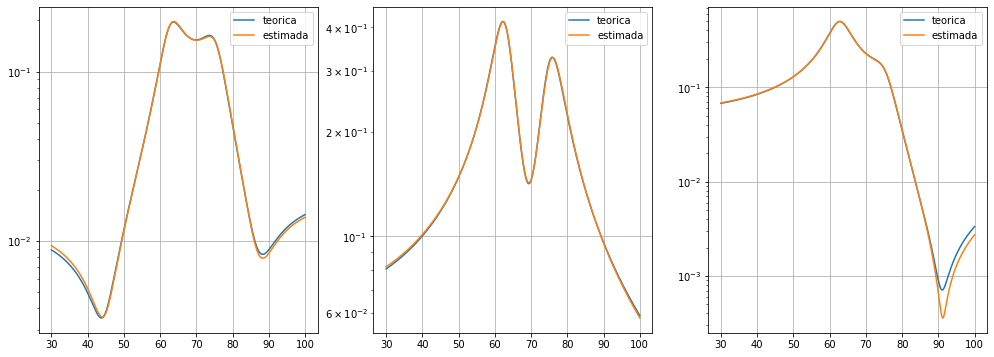

In [14]:
fig, ax= plt.subplots(1, n_dof, figsize=(17,6))
[ax.flat[i].grid(True, markevery=1) for i in range(len(ax.flat))]

for dof in range(n_dof):
    ax.flat[dof].semilogy(w12, np.abs(frf[idx12, dof]), label='teorica')
    ax.flat[dof].semilogy(w12, np.abs(frf_estimates[:, dof]), label='estimada')
    ax.flat[dof].legend()
    plt.plot()

Max value off diagonal: 0.002


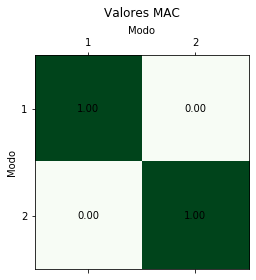

In [18]:
MAC_grfp = mac.get_MAC_matrix(r_n[:,:2], mode_vectors)
mac.plot_MAC(MAC_grfp, 'Greens', 'k')
print('Max value off diagonal: {:.3f}'.format(mac.get_max_off_diagonal(MAC_grfp)))